# **Text preprocessing and dictionary methods**

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/sekhansen/text_algorithms_econ/blob/main/notebooks/2_preprocessing.ipynb)

This notebook illustrates multiple strategies in order to transform raw text into a document-term matrix. As a starting point, we will use the built-in functions from the ```scikit-learn``` library to process our text and generate the document-term matrix. We will then refine this strategy by applying a more complex text preprocessing pipeline.
<br> <br>

The document-term matrix can be used as the input to many bag-of-words text analysis algorithms such as dictionary methods, Latent Semantic Analysis (LSA) or Linear Dirichlet Allocation (LDA). Through the notebook, we will focus on a concrete application of dictionary methods. We will show how the document-term matrix can be used to measure the sentiment of documents and how this sentiment is correlated with economic variables of interest.

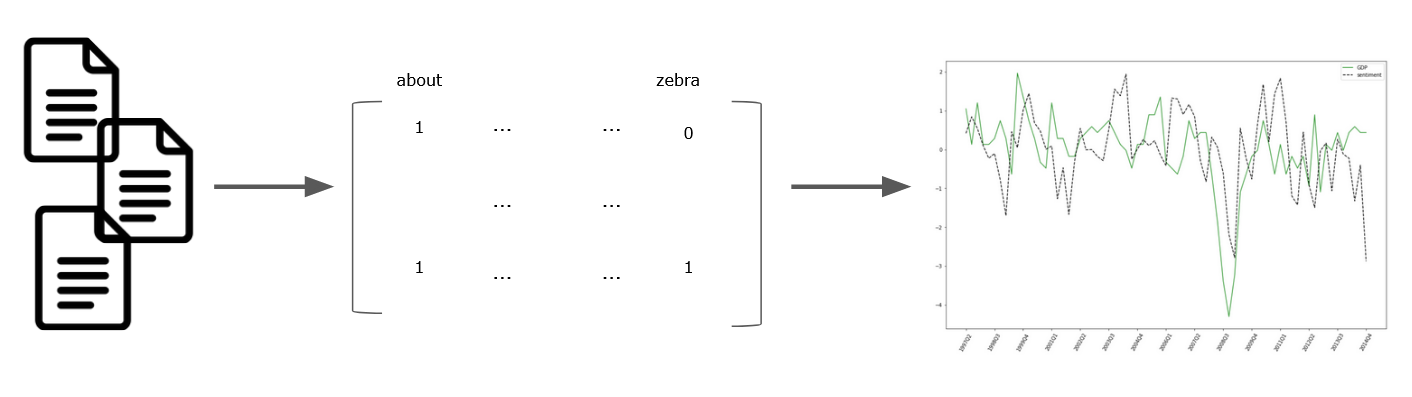

# 0. Setup

In [1]:
%%capture

# install required libraries
!pip3 install flashtext                  # easy phrase replacing methods
!pip3 install contractions               # expand English contractions 
!pip3 install --upgrade spacy==2.2.4     # functions for lemmatizing
!pip3 install gdown                      # download files from Google Drive
!pip3 install nltk                       # NLP library

# install Spacy's language model
# for more languages and models check: https://spacy.io/models
!python3 -m spacy download en_core_web_sm

In [2]:
# clone the GitHub repository with the preprocessing scripts
!git clone https://github.com/unstructured-data-research/text-preprocessing

Cloning into 'text-preprocessing'...
remote: Enumerating objects: 31, done.
remote: Counting objects: 100% (31/31), done.
remote: Compressing objects: 100% (24/24), done.
remote: Total 31 (delta 11), reused 17 (delta 4), pack-reused 0
Unpacking objects: 100% (31/31), 1.95 MiB | 8.68 MiB/s, done.


In [3]:
# import libraries
import pandas as pd
import numpy as np
import gdown
import random
import string
import re
import random
import sys
import matplotlib.pyplot as plt
import seaborn as sns
import contractions
from sklearn.preprocessing import StandardScaler
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

import unicodedata
import spacy
nlp_standard = spacy.load('en_core_web_sm')

import nltk
from nltk import SnowballStemmer
stemmer = SnowballStemmer(language='english')

# import our own modules
sys.path.append('./text-preprocessing/src')
import preprocessing_class as pc
import preprocess_data

In [4]:
# define paths and seed
seed = 92
data_path = "./"

In [5]:
# define dictionary with paths to data in Google Drive
data_url_dict = {"mpc_minutes":             ("https://drive.google.com/uc?id=1k086m12gBHKuVMPv4GUD1aB_kZOZpznR", "txt"),
                 "ons_quarterly_gdp":       ("https://drive.google.com/uc?id=1_8JwCNUsq9wnPiTDmcJ2xrWklGGDFbQD", "csv"),
                 "gdp_sentiment":           ("https://drive.google.com/uc?id=1xxGecTJzbXLMgGE-2-YVKlMD2P0JYmgH", "csv")
                 }

In [6]:
# download each file in the dictionary from Google Drive
for file_name, attributes in data_url_dict.items():
    url = attributes[0]
    extension = attributes[1]
    gdown.download(url, f"{file_name}.{extension}", quiet=False) 

Downloading...
From: https://drive.google.com/uc?id=1k086m12gBHKuVMPv4GUD1aB_kZOZpznR
To: /content/mpc_minutes.txt
100%|██████████| 7.36M/7.36M [00:00<00:00, 53.3MB/s]
Downloading...
From: https://drive.google.com/uc?id=1_8JwCNUsq9wnPiTDmcJ2xrWklGGDFbQD
To: /content/ons_quarterly_gdp.csv
100%|██████████| 3.33k/3.33k [00:00<00:00, 13.4MB/s]
Downloading...
From: https://drive.google.com/uc?id=1xxGecTJzbXLMgGE-2-YVKlMD2P0JYmgH
To: /content/gdp_sentiment.csv
100%|██████████| 2.36k/2.36k [00:00<00:00, 1.85MB/s]


# 1. Load data

This tutorial uses text data from the monetary policy discussions at the Bank of England. Concretely, we use the minutes from the monthly [Monetary Policy Committee](https://www.bankofengland.co.uk/about/people/monetary-policy-committee) meetings. You can browse through all of these minutes [here](https://www.bankofengland.co.uk/monetary-policy-summary-and-minutes/monetary-policy-summary-and-minutes) or explore one particular minute from September 2017 [here](https://www.bankofengland.co.uk/-/media/boe/files/monetary-policy-summary-and-minutes/2017/september-2017.pdf?la=en&hash=48D5F5B648234CFF1EE2AF02A05181107459E0A2).

As a first step, we inspect the data. We observe that we have a total number of 7,277 strings of data (hereafter **documents**) with an associated date (YYYYMM) that ranges between 06/1997 and 10/2014. The average length of a document is roughly 161 words.

In [7]:
# load the data an inspect it
data = pd.read_csv('mpc_minutes.txt', delimiter='\t', header=0, names=['date', 'minutes'])
print(data.shape)
data.head()

(7277, 2)


,date,minutes
0,199706,1 Sections I to V of this minute summarise t...
1,199706,The 12-month growth rate of notes and coins ...
2,199706,"Broad money, too, decelerated in April: its ..."
3,199706,Lending growth continued at around 9% in ...
4,199706,Lending to individuals remained robust in...


In [8]:
# start by reading a document. What are they?
data.loc[929, "minutes"]

'       The Committee noted that the preliminary estimate of 0.2% GDP growth in 1998 Q4 was consistent with the degree of slowdown expected in its November central projection. Some members had feared lower growth, and the possibility of revisions remained. Surveys suggested that consumer and business sentiment had stopped deteriorating and had perhaps improved slightly, possibly helped by the 150 basis point reduction in official interest rates since October. The preliminary data on Q4 expenditure suggested, however, that household spending might have grown by less in relation to income and wealth than the Committee had assumed in November.'

In [9]:
# calculate the average number of words in a document
data["minutes"].apply(lambda x: len(x.split())).mean()

160.6952040676103

In [10]:
# turn date into date format and create quarter column
data['date'] = pd.to_datetime(data.date, format='%Y%m')
data['year'] = data.date.dt.year.astype(int)
data['quarter'] = data.date.dt.quarter.astype(int)
data['date'] = data['date'].dt.strftime('%Y%m')
data.head()

,date,minutes,year,quarter
0,199706,1 Sections I to V of this minute summarise t...,1997,2
1,199706,The 12-month growth rate of notes and coins ...,1997,2
2,199706,"Broad money, too, decelerated in April: its ...",1997,2
3,199706,Lending growth continued at around 9% in ...,1997,2
4,199706,Lending to individuals remained robust in...,1997,2


In [11]:
# inspect the coverage of our data
print('number of months:', len(data.date.unique()))
print('number of years:', len(data.year.unique()))

number of months: 209
number of years: 18


#  2. Preprocessing text with scikit-learn

We will use the ```CountVectorizer``` class from **scikit-learn** in order to both preprocess our text and transform it into a document-term matrix. Check the [documentation of the class](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html) to learn more about its parameters. 

In [12]:
# create a CountVectorizer object straight from the raw text
count_vectorizer = CountVectorizer(token_pattern=r"(?u)\b\w\w+\b",       # regular expression to split documents into tokens
                                   lowercase=True,                       # convert all characters to lower-case
                                   strip_accents="ascii",                # remove non-ascii characters (WARNING: this is dangerous in Romance languages)
                                   stop_words="english",                 # remove stopwords from a built-in list. We can also provide our own list
                                   ngram_range=(1, 1),                   # generate only unigrams
                                   analyzer="word",                      # build matrix at the word-level 
                                   max_df=0.8,                           # ignore tokens that have a higher document frequency (can be int or percent)
                                   min_df=20,                            # ignore tokens that have a lower document frequency (can be int or percent)
                                   max_features=None,                    # we could impose a maximum number of vocabulary terms
                                   )                       
count_vectorizer

CountVectorizer(max_df=0.8, min_df=20, stop_words='english',
                strip_accents='ascii')

In [13]:
# directly transform our data into a document-term matrix. We just need to pass
# our documents as an argument to the fit_transform function
dt_matrix_simple = count_vectorizer.fit_transform(data["minutes"])
print(f"Document-term matrix created with shape: {dt_matrix_simple.shape}")    # (documents, vocabulary size)

Document-term matrix created with shape: (7277, 2313)


In [14]:
# inspect the document-term matrix. Why is it sparse?
dt_matrix_simple

<7277x2313 sparse matrix of type '<class 'numpy.int64'>'
	with 384051 stored elements in Compressed Sparse Row format>

In [15]:
# transform to regular numpy array to easily manipulate.
# this might not be convenient (or even possible) if your matrix is too large
dt_matrix_simple = dt_matrix_simple.toarray()

In [16]:
# we can explore the vocaburaly as pairs of (word, position in matrix)
vocabulary = count_vectorizer.vocabulary_
random.sample(list(vocabulary.items()), 10)

[('notable', 1414),
 ('300', 59),
 ('undertaken', 2180),
 ('recruit', 1729),
 ('access', 146),
 ('91', 105),
 ('revival', 1833),
 ('marian', 1301),
 ('mild', 1346),
 ('consumers', 529)]

In [17]:
# another way of looking at the vocabulary (ordered by index in the document-term matrix)
count_vectorizer.get_feature_names_out()

array(['000', '10', '100', ..., 'yields', 'yougov', 'zero'], dtype=object)

# 3. Tracking the sentiment towards the economy

Consider a situation where we want to investigate the overall sentiment of each monetary policy meeting. This migth be a very interesting quantity since it reflects the perception that policy makers have of the current state of the economy.
<br><br>

A simple and sensible way to estimate this quantity would be to build a document-sentiment index based on the difference between the number of words having a "positive" sentiment and those having a "negative" sentiment in a document. **We will use our document-term matrix to do precisely this**. For each document $i$ we will calculate:
<br><br>

$$
\text{net sentiment}_i = \frac{{\text{# Positive terms}_i} - \text{# Negative terms}_i}{{\text{# Positive terms}_i} + \text{# Negative terms}_i}
$$

<br><br>
We will then evaluate such an index by comparing the measured sentiment with the UK's GDP growth.


## Building dictionaries

Firstly, we need to define the terms having positive or negative sentiment. For this example, we use a set of terms from [Apel and Blix-Grimaldi (2012)](http://archive.riksbank.se/Documents/Rapporter/Working_papers/2012/rap_wp261_120426.pdf) who analyzed the minutes from the Swedish Central Bank. In general, it is a good practice to build on dictionaries that have been already used in the literature.

In [18]:
pos_words = ["high", "higher", "highest",
             "strong", "stronger", "strongest",
             "increase", "increases", "increased","increasing",
             "fast", "faster", "fastest"]

In [19]:
neg_words = ["low", "lower", "lowest",
             "weak", "weaker", "weakest",
             "decrease", "decreases", "decreased", "decreasing",
             "slow", "slower", "slowest"]

In [20]:
# find the position in the document-term matrix of each word from the dictionary
pos_ixs = [v for k,v in vocabulary.items() if k in pos_words]
neg_ixs = [v for k,v in vocabulary.items() if k in neg_words]

In [21]:
# for each document, sum all the positive words
pos_counts = np.take(dt_matrix_simple, pos_ixs, axis=1)
pos_counts = pos_counts.sum(axis=1)

# for each document, sum all the negative words
neg_counts = np.take(dt_matrix_simple, neg_ixs, axis=1)
neg_counts = neg_counts.sum(axis=1)

In [22]:
# add counts to dataframe
data['pos_counts_simple'] = pos_counts
data['neg_counts_simple'] = neg_counts
data

,date,minutes,year,quarter,pos_counts_simple,neg_counts_simple
0,199706,1 Sections I to V of this minute summarise t...,1997,2,0,0
1,199706,The 12-month growth rate of notes and coins ...,1997,2,0,0
2,199706,"Broad money, too, decelerated in April: its ...",1997,2,2,0
3,199706,Lending growth continued at around 9% in ...,1997,2,1,0
4,199706,Lending to individuals remained robust in...,1997,2,1,0
...,...,...,...,...,...,...
7272,201410,"For most members, there remained insuffi...",2014,4,4,4
7273,201410,"Set against this, the level of Bank Rate...",2014,4,0,4
7274,201410,"For two members, economic circumstances ...",2014,4,1,1
7275,201410,The Governor invited the Committee to vo...,2014,4,1,0


In [23]:
# aggregate all minutes to the year-quarter level (by summing all the counts)
data_agg = data.loc[:, ['year', 'quarter', 'pos_counts_simple', 'neg_counts_simple']].groupby(['year', 'quarter'], as_index=False).sum()
data_agg.head()

,year,quarter,pos_counts_simple,neg_counts_simple
0,1997,2,27,10
1,1997,3,222,72
2,1997,4,229,86
3,1998,1,254,113
4,1998,2,255,131


In [24]:
# compute net positive sentiment
data_agg['net_sentiment_simple'] = (data_agg.pos_counts_simple - data_agg.neg_counts_simple)/(data_agg.pos_counts_simple + data_agg.neg_counts_simple)
data_agg = data_agg[['year', 'quarter', 'net_sentiment_simple']].copy()
data_agg.head()

,year,quarter,net_sentiment_simple
0,1997,2,0.459459
1,1997,3,0.510204
2,1997,4,0.453968
3,1998,1,0.384196
4,1998,2,0.321244


Next we add quarterly GDP data collected from the ONS website in order to compare our sentiment index with GDP growth.

In [25]:
# load GDP data
df_gdp = pd.read_csv('ons_quarterly_gdp.csv', names=['label', 'gdp_growth', 'quarter_long'], header=0)
df_gdp['year'] = df_gdp.label.apply(lambda x: x[:4]).astype(int)
df_gdp['quarter'] = df_gdp.label.apply(lambda x: x[6]).astype(int)
df_gdp = df_gdp[['year', 'quarter', 'gdp_growth']]
df_gdp = df_gdp.drop_duplicates().reset_index(drop=True).copy()
df_gdp.head()

,year,quarter,gdp_growth
0,1997,2,1.2
1,1997,3,0.6
2,1997,4,1.3
3,1998,1,0.6
4,1998,2,0.6


In [26]:
# merge both dataframes
df = data_agg.merge(df_gdp, how='left', on=['year', 'quarter']).copy()
df.head()

,year,quarter,net_sentiment_simple,gdp_growth
0,1997,2,0.459459,1.2
1,1997,3,0.510204,0.6
2,1997,4,0.453968,1.3
3,1998,1,0.384196,0.6
4,1998,2,0.321244,0.6


In [27]:
# check correlation betweeen both series
print(df[['gdp_growth', 'net_sentiment_simple']].corr())

                      gdp_growth  net_sentiment_simple
gdp_growth              1.000000              0.277038
net_sentiment_simple    0.277038              1.000000


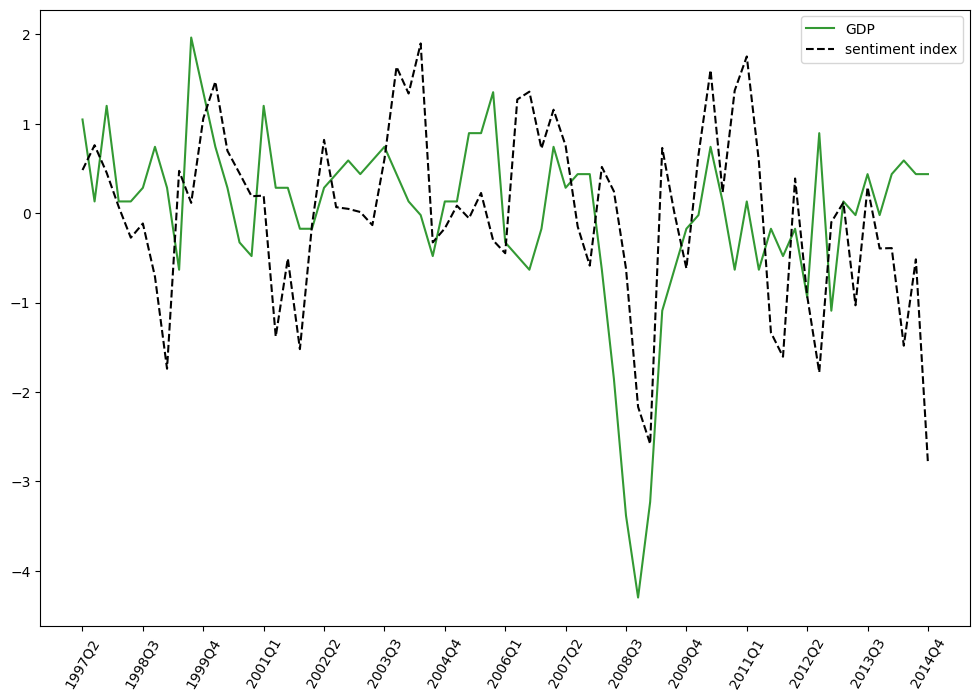

In [28]:
# plot standardized series for growth and sentiment
scaler = StandardScaler()
ticks = np.arange(0, df.shape[0], 5)
labs = np.array([str(x)+'Q'+str(y) for x,y in zip(df['year'],df['quarter'])])
labs = labs[ticks]

fig, ax = plt.subplots(figsize=(12,8))
ax.plot(scaler.fit_transform(df.gdp_growth.values.reshape(-1, 1)).flatten(), 
        label='GDP', c='green', alpha=0.8)
ax.plot(scaler.fit_transform(df["net_sentiment_simple"].values.reshape(-1, 1)).flatten(), 
        label='sentiment index', linestyle='dashed', c='black')

ax.set_xticks(ticks)
ax.set_xticklabels(labs, rotation=60)
ax.legend()
plt.show()

## Downsides of simple preprocessing

Although ```scikit-learn``` makes it easy to preprocess text and transform it into a document-term matrix, we might want to go beyond the functionality provided by this library. For instance we may want to:
+ Split contractions (e.g. don't --> do not)
+ Remove all numbers
+ Transform words into lemmas
+ Transform words into stems
+ **Read documents while we are transforming them**
<br><br>

In the next section, we will show how to implement these custom preprocessing steps.

# 4. Custom preprocessing pipeline

## Basic cleaning

In [29]:
# lower case via the lower() built-in method
docs = [s.lower() for s in data.minutes]

In [30]:
# remove leading and trailing whitespaces
docs = [d.strip() for d in docs]

In [31]:
# split contractions with the "contractions" library
# the library mainly supports English but it provides the tools to extend its
# functionality to other languages: https://github.com/kootenpv/contractions
contractions.fix("We can't increase the interest rate. They won't accept it. It's too risky.")

'We cannot increase the interest rate. They will not accept it. It is too risky.'

In [32]:
# apply contractions function
docs = list(map(lambda x: contractions.fix(x), docs))

In [33]:
# tokenize with the spaCy tokenizer
def spacy_tokenizer_standard(sent):
    sent = nlp_standard.tokenizer(sent)
    tokens = [t.text for t in sent]
    return tokens

# apply function
tokens = list(map(spacy_tokenizer_standard, docs))

In [34]:
# we could use apply our own regular expression
custom_pattern = r'''
                 (?x)                # set flag to allow verbose regexps (to separate logical sections of pattern and add comments)
                 \w+(?:-\w+)*        # word characters with internal hyphens
                 | [][.,;"'?():-_`]  # preserve punctuation as separate tokens
                 '''

tokens_custom = list(map(lambda x:nltk.regexp_tokenize(x, pattern=custom_pattern), docs))

In [35]:
# inspect a document to see the differences in the tokenization
i = 10
print(data.loc[i, "minutes"][0:118], "\n")
print(tokens[i][0:16])
print(tokens_custom[i][0:16])

  There was as yet no clear downtrend in net exports. Exports to non-EU countries had risen sharply: the USA had grown 

['there', 'was', 'as', 'yet', 'no', 'clear', 'downtrend', 'in', 'net', 'exports', '.', 'exports', 'to', 'non', '-', 'eu']
['there', 'was', 'as', 'yet', 'no', 'clear', 'downtrend', 'in', 'net', 'exports', '.', 'exports', 'to', 'non-eu', 'countries', 'had']


In [36]:
# remove non-ascii characters via unicodedata package
def remove_non_ascii(tokens):
    tokens = [unicodedata.normalize('NFKD', t).encode('ascii', 'ignore').decode('utf-8', 'ignore') for t in tokens]
    return tokens
    
# apply function
tokens = list(map(remove_non_ascii, tokens))

In [37]:
# BRIEF NOTE: Removing non-ascii characters from other languages is very dangerous.
# You will loose a lot of information
unicodedata.normalize('NFKD', "à è ü ç").encode('ascii', 'ignore').decode('utf-8', 'ignore')

'a e u c'

In [38]:
# remove extra white spaces and short tokens via simple list comprehension
def remove_short(tokens, min_length=2):
    return [t.strip() for t in tokens if t.strip() != '' and len(t.strip()) > min_length] 

# apply function
tokens = list(map(remove_short, tokens))

In [39]:
# remove punctuation using a regular expression. We can use this same 
# structure to remove any other character
def remove_punctuation(tokens, punctuation):            
    regex = re.compile('[%s]' % re.escape(punctuation))
    tokens = [regex.sub('', t) for t in tokens]
    return tokens

# load a list of punctuation signs
string.punctuation

'!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [40]:
# apply punctuation removal function
tokens = list(map(lambda x: remove_punctuation(x, string.punctuation), tokens))

In [41]:
# remove stopwords via simple list comprehension
def remove_stopwords(tokens, stopwords):
    return [t for t in tokens if t not in stopwords]

# load a custom list of stopwords
custom_stopwords = list(preprocess_data.stp_long)
custom_stopwords[0:10]

['another', 'had', 'go', 'but', 'my', 'like', 'and', 'make', 'put', 'herself']

In [42]:
# apply stopword removal function
tokens = list(map(lambda x: 
                  remove_stopwords(x, stopwords=custom_stopwords),
                  tokens))

In [43]:
# remove numbers
def remove_numbers(tokens, min_length=2):
    translation_table = str.maketrans('', '', string.digits)
    tokens = [t.translate(translation_table) for t in tokens if not t.isdigit()] 
    return  [t for t in tokens if t != '' and len(t) > min_length]

# apply number removal function
tokens = list(map(lambda x: 
                  remove_numbers(x, min_length=2),
                  tokens))

## Stemming and lemmatization

As a next step, one might attempt to group together words that are grammatically different but thematically identical. For example, it could be reasonable to keep words such as *'obligations'*, *'obligation'* and  *'oblige'* under a single token. Ultimately these three words denote the same concept, and so we might want them to share the same symbol. 

The two most popular techniques to achieve this goal are **stemming** and **lemmatization**.  
>Stemming replaces each word with its root form. The resulting token is less readable by humans but encompases multiple words (e.g. *'tradition'* and *'traditional'* have the same stem: *'tradit'*). 

>Lemmatization replaces words with their dictionary form i.e. lemma. The words *'changing'*, *'changes'* and *'changed'* all have the same lemma: *'change'*.

Below, we use both techniques (stemming [via nltk Snowball stemmer](https://www.geeksforgeeks.org/snowball-stemmer-nlp/) and lemmatization via [spaCy lemmatizer](https://spacy.io/api/lemmatizer)) and look at the different results on a specific document.

In [44]:
# stem via standard nltk Snowball Stemmer
stemmer = SnowballStemmer(language='english')
def stem(tokens):
    """stem all tokens that do not contain hyphens"""
    return [stemmer.stem(t) if "-" not in t else t for t in tokens]

# apply function
stems = list(map(stem, tokens))

In [45]:
# inspect a document
i = 10
print(data.loc[i, "minutes"][0:162], "\n")
print(stems[i][0:14])

  There was as yet no clear downtrend in net exports. Exports to non-EU countries had risen sharply: the USA had grown very fast in Q1, but it was expected by US  

['yet', 'clear', 'downtrend', 'net', 'export', 'export', 'non', 'countri', 'risen', 'sharpli', 'usa', 'grown', 'fast', 'expect']


In [46]:
# lemmatize with standard spaCy lemmatizer (takes a couple of minutes)
nlp_standard = spacy.load('en_core_web_sm')
def lemmatize_sent(sent):
    sent = ' '.join(sent)
    doc = nlp_standard(sent)
    lemmas = [token.lemma_ if token.lemma_ != '-PRON-' else token.text for token in doc]
    return lemmas

# apply function
lemmas = list(map(lemmatize_sent, tokens))

In [47]:
# compare the same document
i = 10
print(data.loc[i, "minutes"][0:162], "\n")
print("Stems: ", stems[i][0:14], "\n")
print("Lemmas: ", lemmas[i][0:14])

  There was as yet no clear downtrend in net exports. Exports to non-EU countries had risen sharply: the USA had grown very fast in Q1, but it was expected by US  

Stems:  ['yet', 'clear', 'downtrend', 'net', 'export', 'export', 'non', 'countri', 'risen', 'sharpli', 'usa', 'grown', 'fast', 'expect'] 

Lemmas:  ['yet', 'clear', 'downtrend', 'net', 'export', 'export', 'non', 'country', 'rise', 'sharply', 'usa', 'grow', 'fast', 'expect']


## Restricting the vocabulary by looking at the term frequency

Finally, one might want to drop very frequent terms, as they could be regarded as corpus-specific terms that do not add up much value. Similarly, one might want to drop very rare terms, considering that not much can be learnt from such infrequent items. 

To explore these ideas we will rank tokens according to pure document frequency (df) or term frequency inverse document frequency (tf-idf), where high weight is given to terms that appear frequently in the entire dataset, but in relatively few documents. In particular, the tf-idf score for term $v$ is computed according to the formula below:

\begin{equation}
tfidf_v = (1+log(tf_v)) (log \frac{N}{df_v+1})
\end{equation}

In [48]:
# simple auxiliary function to override the preprocessing done by sklearn
def do_nothing(doc):
    return doc

In [49]:
# generate document frequency ranking for all terms in the vocabulary
vectorizer = TfidfVectorizer(use_idf=False, norm=None, tokenizer=do_nothing, preprocessor=do_nothing) 
df_matrix = vectorizer.fit_transform(tokens).toarray()
df_matrix_bool = np.where(df_matrix > 0, 1, 0)
scores_df = df_matrix_bool.sum(axis=0)

sorted_vocab = sorted(vectorizer.vocabulary_.items(),   key=lambda x: x[1])
sorted_vocab_keys = list(np.array(sorted_vocab)[:,0])
sorted_scores_df = sorted(set(scores_df), reverse=True)

rank_dict = {k:val for k,val in zip(sorted_scores_df, list(range(len(sorted_scores_df))))}
rank_tup = sorted(zip(scores_df, sorted_vocab_keys),  key=lambda x: x[0], reverse=True)
df_ranking = [x + (rank_dict[x[0]],) for x in rank_tup]
df_ranking[:10]

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


[(3431, 'growth', 0),
 (3062, 'inflation', 1),
 (2641, 'rate', 2),
 (2489, 'committee', 3),
 (2388, 'prices', 4),
 (2294, 'market', 5),
 (2163, 'month', 6),
 (1941, 'demand', 7),
 (1905, 'remained', 8),
 (1862, 'output', 9)]

As we can see, the token "growth" ranks first, with a document frequency of 3,431 out of 7,277 (i.e. "growth" is present in around 47% of the documents), and "inflation" and "rate" come right after. Let's now look at the top ranked tokens in terms of tf-df:

In [50]:
# function to compute term-frequency inverse document frequency
def tf_idf_compute(term, num_docs, scores_tf, scores_df):
    return (1+np.log(scores_tf[term])*np.log(num_docs/scores_df[term]))

# generate term frequency inverse document frequency ranking for all terms in the vocabulary
sorted_vocab = sorted(vectorizer.vocabulary_.items(),   key=lambda x: x[1])
sorted_vocab = list(np.array(sorted_vocab)[:,0])
scores_tf = df_matrix.sum(axis=0)
scores_tfidf = [tf_idf_compute(t, len(tokens), scores_tf=scores_tf, scores_df=scores_df) for t in range(len(sorted_vocab))]
sorted_scores_tfidf = sorted(set(scores_tfidf), reverse=True)

rank_dict = {k:val for k,val in zip(sorted_scores_tfidf, list(range(len(sorted_scores_tfidf))))}
rank_tup = sorted(zip(scores_tfidf, sorted_vocab),  key=lambda x: x[0], reverse=True)
tfidf_ranking = [x + (rank_dict[x[0]],) for x in rank_tup]
tfidf_ranking[:10]

[(25.89188880741839, 'securitisations', 0),
 (25.517881250415055, 'ips', 1),
 (24.794963009728445, 'nfc', 2),
 (24.658359148064065, 'bcc', 3),
 (24.460899792318422, 'pnfcsa', 4),
 (24.163147658906983, 'annex', 5),
 (23.920156435028385, 'respectively', 6),
 (23.786282775779966, 'egarding', 7),
 (23.76832183070415, 'attacks', 8),
 (23.688367959279212, 'surplus', 9)]

The two methods do not agree. Indeed, tf-idf weights more those terms that are frequent, but in relatively few documents.
<br><br>

Let's now inspect the overall behavior of the document frequency ranking and the tf-idf ranking. As we can see, document frequency decays very fast (following a power-law), while tf-idf decreases at a slower pace.

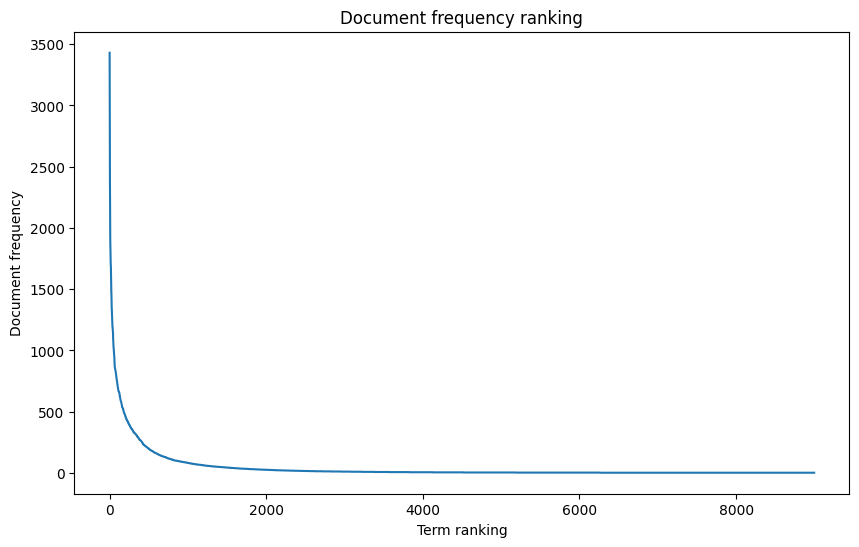

In [51]:
# plot document frequency
plt.figure(figsize=(10,6))
plt.plot([x[0] for x in df_ranking])
plt.title('Document frequency ranking')
plt.ylabel("Document frequency")
plt.xlabel("Term ranking")
plt.show()

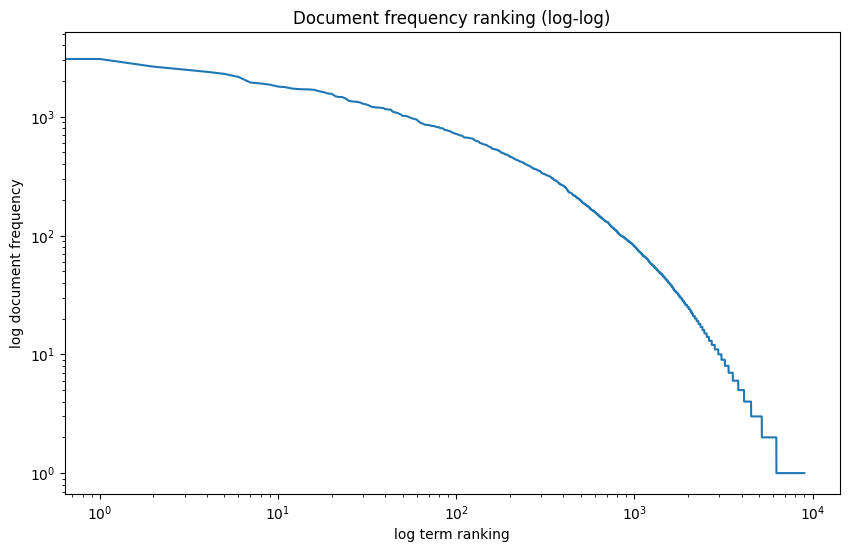

In [52]:
# we can use a log-log scale to observe more clearly the power-law distribution (Zipf's law)
plt.figure(figsize=(10,6))
plt.loglog([x[0] for x in df_ranking])
plt.title('Document frequency ranking (log-log)')
plt.ylabel("log document frequency")
plt.xlabel("log term ranking")
plt.show()

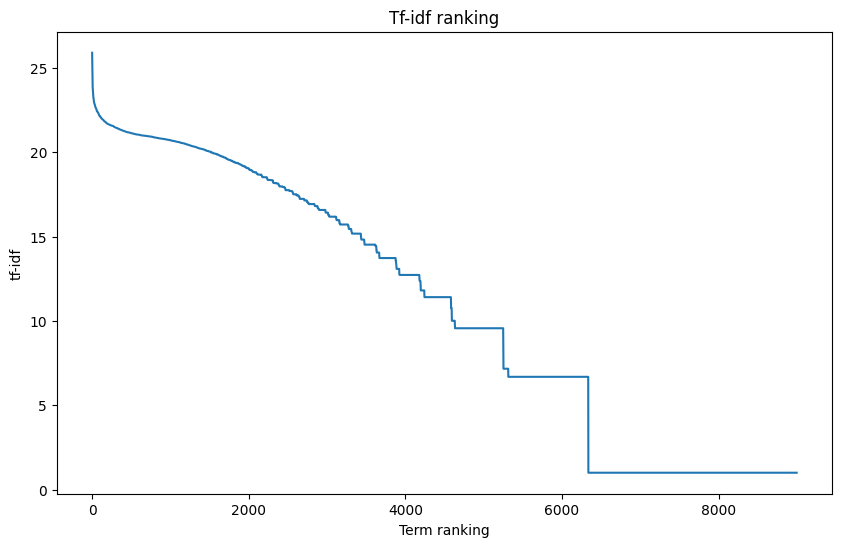

In [53]:
# plot tf-ids ranking
plt.figure(figsize=(10,6))
plt.plot([x[0] for x in tfidf_ranking])
plt.title('Tf-idf ranking')
plt.ylabel("tf-idf")
plt.xlabel("Term ranking")
plt.show()

Using the *tfidf* ranking, for instance, we can see that removing stems that have a score lower than the score of stems in positions around 5,800 might be reasonable; they are relatively uninformative and lots of them have a similar score.


In [54]:
# get the score of the stem in position 58000
tfidf_ranking[5800][0]

6.68334024544429

In [55]:
# auxiliary function to easily remove undesired tokens
def remove(tokens, to_remove):
    if to_remove:
        return [t for t in tokens if t not in to_remove]
    else:
        return tokens

# function to remove tokens in documents according to their df or tfidf score 
def rank_remove(ranking, docs, min_cutoff_score=-np.inf, max_cutoff_score=np.inf):

    # define list of tokens to remove
    to_remove_low = set([t[1] for t in ranking if t[0] <= min_cutoff_score])
    to_remove_high = set([t[1] for t in ranking if t[0] > max_cutoff_score])

    # remove tokens
    docs_clean = [remove(d, to_remove_low) for d in docs]
    docs_clean = [remove(d, to_remove_high) for d in docs]

    return docs_clean

In [56]:
# update documents
stems_clean = rank_remove(tfidf_ranking, stems, min_cutoff_score=tfidf_ranking[5800][0])

In [57]:
# we can also remove stems that have a very high score
stems_clean = rank_remove(tfidf_ranking, stems_clean, max_cutoff_score=20)

## Vectorization

Now that we have finished preprocessing our text we will use again ```scikit-learn``` to transform our list of tokens, lemmas or stems into a document-term matrix. Check the documentation for the [```CountVectorizer```](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html) and the [```TfidfVectorizer```](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html#sklearn.feature_extraction.text.TfidfVectorizer) to explore all the parameters and functionalities of these classes.

In [58]:
# create a CountVectorizer object straight from the raw text
count_vectorizer = CountVectorizer(preprocessor=do_nothing,              # apply no additional preprocessing
                                   tokenizer=do_nothing,                 # apply no additional tokenization
                                   lowercase=False,                      # convert all characters to lower-case
                                   strip_accents=None,                   # remove non-ascii characters
                                   stop_words=None,                      # remove stopwords from a built-in list. We can also provide our own list
                                   ngram_range=(1, 1),                   # generate only unigrams
                                   analyzer='word',                      # analysis at the word-level 
                                   max_df=1.0,                           # ignore tokens that have a higher document frequency (can be int or percent)
                                   min_df=0,                             # ignore tokens that have a lowe document frequency (can be int or percent)
                                   max_features=None,                    # we could impose a maximum number of vocabulary terms
                                   )                       
count_vectorizer

CountVectorizer(lowercase=False, min_df=0,
                preprocessor=<function do_nothing at 0x7fe75f4daf80>,
                tokenizer=<function do_nothing at 0x7fe75f4daf80>)

In [59]:
# create the document term matrix using stems
dt_matrix_custom = count_vectorizer.fit_transform(stems_clean).toarray()
vocabulary_custom = count_vectorizer.vocabulary_
print(len(vocabulary_custom))

5048


In [60]:
# we can also create a weighted vectorizer object
# however we will not use it in the analysis
weighted_vectorizer = TfidfVectorizer(preprocessor=do_nothing,              # apply no additional preprocessing
                                      tokenizer=do_nothing,                 # apply no additional tokenization
                                      lowercase=False,                      # convert all characters to lower-case
                                      strip_accents=None,                   # remove non-ascii characters
                                      stop_words=None,                      # remove stopwords from a built-in list. We can also provide our own list
                                      ngram_range=(1, 1),                   # generate only unigrams
                                      analyzer='word',                      # analysis at the word-level 
                                      max_df=0.8,                           # ignore tokens that have a higher document frequency (can be int or percent)
                                      min_df=20,                            # ignore tokens that have a lowe document frequency (can be int or percent)
                                      max_features=None,                    # we could impose a maximum number of vocabulary terms
                                      
                                      use_idf=True,                         # wether to apply inverse document frequency weights
                                      smooth_idf=True,                      # add +1 to idf weighting
                                      sublinear_tf=True                     # add +1 to log(tf)
                                   )                       
weighted_vectorizer

TfidfVectorizer(lowercase=False, max_df=0.8, min_df=20,
                preprocessor=<function do_nothing at 0x7fe75f4daf80>,
                sublinear_tf=True,
                tokenizer=<function do_nothing at 0x7fe75f4daf80>)

## Dictionary methods

In [61]:
# transform dictionary terms into stems (in order for them to match our new vocabulary)
pos_stems = [stemmer.stem(t) for t in pos_words]
pos_stems = list(set(pos_stems))
neg_stems = [stemmer.stem(t) for t in neg_words]
neg_stems = list(set(neg_stems))

In [62]:
# find positions of the stems in the document-term matrix
pos_ixs = [v for k,v in vocabulary_custom.items() if k in pos_stems]
neg_ixs = [v for k,v in vocabulary_custom.items() if k in neg_stems]

In [63]:
# count positive stems per document
pos_counts_custom = np.take(dt_matrix_custom, pos_ixs, axis=1)
pos_counts_custom = pos_counts_custom.sum(axis=1)

# count negative stems per document
neg_counts_custom = np.take(dt_matrix_custom, neg_ixs, axis=1)
neg_counts_custom = neg_counts_custom.sum(axis=1)

In [64]:
# add counts to dataframe
data['pos_counts_custom'] = pos_counts_custom
data['neg_counts_custom'] = neg_counts_custom
data

,date,minutes,year,quarter,pos_counts_simple,neg_counts_simple,pos_counts_custom,neg_counts_custom
0,199706,1 Sections I to V of this minute summarise t...,1997,2,0,0,0,0
1,199706,The 12-month growth rate of notes and coins ...,1997,2,0,0,0,0
2,199706,"Broad money, too, decelerated in April: its ...",1997,2,2,0,2,0
3,199706,Lending growth continued at around 9% in ...,1997,2,1,0,1,0
4,199706,Lending to individuals remained robust in...,1997,2,1,0,1,0
...,...,...,...,...,...,...,...,...
7272,201410,"For most members, there remained insuffi...",2014,4,4,4,4,5
7273,201410,"Set against this, the level of Bank Rate...",2014,4,0,4,0,4
7274,201410,"For two members, economic circumstances ...",2014,4,1,1,1,1
7275,201410,The Governor invited the Committee to vo...,2014,4,1,0,1,0


In [65]:
# aggregate to year-quarter level
data_agg = data.groupby(['year', 'quarter']).sum(numeric_only=True).reset_index()
data_agg.head()

,year,quarter,pos_counts_simple,neg_counts_simple,pos_counts_custom,neg_counts_custom
0,1997,2,27,10,21,10
1,1997,3,222,72,206,70
2,1997,4,229,86,215,100
3,1998,1,254,113,234,139
4,1998,2,255,131,227,162


In [66]:
# compute net sentiment
data_agg['net_sentiment_simple'] = (data_agg.pos_counts_simple - data_agg.neg_counts_simple)/(data_agg.pos_counts_simple + data_agg.neg_counts_simple)
data_agg['net_sentiment_custom'] = (data_agg.pos_counts_custom - data_agg.neg_counts_custom)/(data_agg.pos_counts_custom + data_agg.neg_counts_custom)

data_agg = data_agg[['year', 'quarter', 'net_sentiment_simple', 'net_sentiment_custom']].copy()
data_agg.head()

,year,quarter,net_sentiment_simple,net_sentiment_custom
0,1997,2,0.459459,0.354839
1,1997,3,0.510204,0.492754
2,1997,4,0.453968,0.365079
3,1998,1,0.384196,0.254692
4,1998,2,0.321244,0.167095


In [67]:
# merge to GDP data
df = data_agg.merge(df_gdp, how='left', on=['year', 'quarter']).copy()
df.head()

,year,quarter,net_sentiment_simple,net_sentiment_custom,gdp_growth
0,1997,2,0.459459,0.354839,1.2
1,1997,3,0.510204,0.492754,0.6
2,1997,4,0.453968,0.365079,1.3
3,1998,1,0.384196,0.254692,0.6
4,1998,2,0.321244,0.167095,0.6


Looking at correlations, we see that the new sentiment index is slightly more correlated with GDP than our initial measure.

In [68]:
print(df[['gdp_growth', 'net_sentiment_simple', "net_sentiment_custom"]].corr())

                      gdp_growth  net_sentiment_simple  net_sentiment_custom
gdp_growth              1.000000              0.277038              0.288730
net_sentiment_simple    0.277038              1.000000              0.964843
net_sentiment_custom    0.288730              0.964843              1.000000


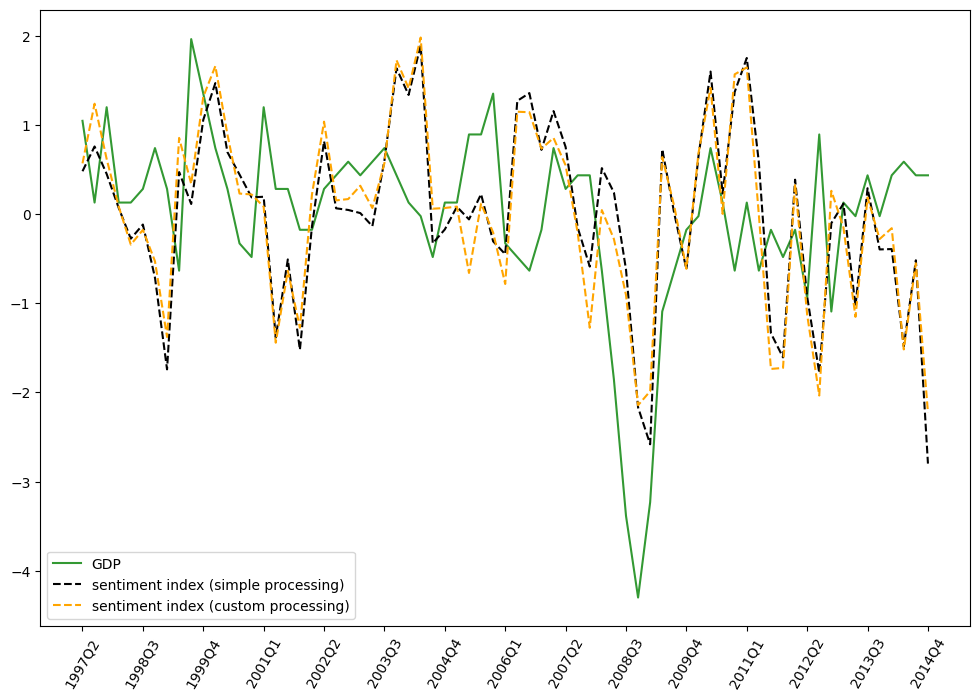

In [69]:
# plot time series
scaler = StandardScaler()
ticks = np.arange(0, df.shape[0], 5)
labs = np.array([str(x)+'Q'+str(y) for x,y in zip(df['year'],df['quarter'])])
labs = labs[ticks]

fig, ax = plt.subplots(figsize=(12,8))
ax.plot(scaler.fit_transform(df.gdp_growth.values.reshape(-1, 1)).flatten(), 
        label='GDP', c='green', alpha=0.8)

ax.plot(scaler.fit_transform(df["net_sentiment_simple"].values.reshape(-1, 1)).flatten(), 
        label='sentiment index (simple processing)', linestyle='dashed', c='black')

ax.plot(scaler.fit_transform(df["net_sentiment_custom"].values.reshape(-1, 1)).flatten(), 
        label='sentiment index (custom processing)', linestyle='dashed', c='orange')

ax.set_xticks(ticks)
ax.set_xticklabels(labs, rotation=60)
ax.legend()
plt.show()